In [ ]:
! pip install tensorflow.keras

In [ ]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import zipfile
import shutil


import numpy as np
import random as python_random
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
# from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping


# TO-DO (Aiza and Katherine)
### 1. ADD FPR graph that looks like last TPR graphs for all protected attributes
### 2. Clean up Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Train and Test datasets

In [ ]:
import pickle

def read_df_from_pickle(file_path):
  with open(file_path, 'rb') as f:
    df = pickle.load(f)
  return df

In [ ]:
train_df_original_data = read_df_from_pickle('/content/drive/My Drive/Copy of final_train_df.pkl')
# train_df_faiss_dedup = read_df_from_pickle('/content/drive/My Drive/Copy of deduplicated_train_df_ver2.pkl')
# train_df_kmeans_dedup = read_df_from_pickle('/content/drive/My Drive/Copy of kmeans_deduplicated_train_df.pkl')
# train_df_minibatch_dedup = read_df_from_pickle('/content/drive/My Drive/Copy of deduplicated_train_df_minibatch.pkl')
# train_df_kmeans_500_dedup = read_df_from_pickle('/content/drive/My Drive/Copy of kmeans_500_deduplicated_train_df.pkl')
# train_df_kmeans_1500_dedup = read_df_from_pickle('/content/drive/My Drive/Copy of kmeans_1500_deduplicated_train_df.pkl')
test_df = read_df_from_pickle('/content/drive/My Drive/Copy of final_test_df_new.pkl')


In [ ]:
subgroups = test_df.iloc[:, -4:]

In [ ]:
# train_df_faiss_dedup = train_df_faiss_dedup.iloc[:, :-1]
# train_df_kmeans_dedup = train_df_kmeans_dedup.iloc[:, :-1]
# train_df_minibatch_dedup = train_df_minibatch_dedup.iloc[:, :-1]
# train_df_kmeans_500_dedup = train_df_kmeans_500_dedup.iloc[:, :-1]
# train_df_kmeans_1500_dedup = train_df_kmeans_1500_dedup.iloc[:, :-1]


In [ ]:
# split train_df cloumn-wise with last 18 columns and the rest
# Last 18 columns are the 14 disease labels are age, race, insurance and gender.

train_df_embedding_original = train_df_original_data.iloc[:, :-18]
train_df_original_labels = train_df_original_data.iloc[:, -18:]

# train_df_embedding_faiss = train_df_faiss_dedup.iloc[:, :-18]
# train_df_faiss_labels = train_df_faiss_dedup.iloc[:, -18:]

# train_df_embedding_kmeans = train_df_kmeans_dedup.iloc[:, :-18]
# train_df_kmeans_labels = train_df_kmeans_dedup.iloc[:, -18:]

# train_df_embedding_minibatch = train_df_minibatch_dedup.iloc[:, :-18]
# train_df_minibatch_labels = train_df_minibatch_dedup.iloc[:, -18:]

# train_df_kmeans_500_dedup_embedding = train_df_kmeans_500_dedup.iloc[:, :-18]
# train_df_kmeans_500_dedup_labels = train_df_kmeans_500_dedup.iloc[:, -18:]

# train_df_kmeans_1500_dedup_embedding = train_df_kmeans_1500_dedup.iloc[:, :-18]
# train_df_kmeans_1500_dedup_labels = train_df_kmeans_1500_dedup.iloc[:, -18:]

test_df_embedding_data = test_df.iloc[:, :-18]
test_df_labels = test_df.iloc[:, -18:]


In [ ]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']


## Get the X_train and X_test and y_train and y_test

In [ ]:
# The last 4 columns are race, gender, age and insurance so I am removing them here.
def get_x_y(df_labels, df):
  X = df
  y = df_labels.iloc[:, :-4]
  return X, y

X_train_original, y_train_original = get_x_y(train_df_original_labels ,train_df_embedding_original)
# X_train_faiss, y_train_faiss = get_x_y(train_df_faiss_labels, train_df_embedding_faiss)
# X_train_kmeans, y_train_kmeans = get_x_y(train_df_kmeans_labels, train_df_embedding_kmeans)
# X_train_minibatch, y_train_minibatch = get_x_y(train_df_minibatch_labels, train_df_embedding_minibatch)
# X_train_kmeans_500_dedup, y_train_kmeans_500_dedup = get_x_y(train_df_kmeans_500_dedup_labels, train_df_kmeans_500_dedup_embedding)
# X_train_kmeans_1500_dedup, y_train_kmeans_1500_dedup = get_x_y(train_df_kmeans_1500_dedup_labels, train_df_kmeans_1500_dedup_embedding)

X_test, y_test = get_x_y(test_df_labels, test_df_embedding_data)

## Defining the DNN for the baseline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class BaselineModel():
  def __init__(self, model_name):
    self.model = self.createModel()
    self.name = model_name

  def createModel(self):
    model = keras.Sequential([
    layers.Input(shape=(1376,), name="input_1"),  # Input layer with 1376 features: the size of vector embeddings.
    layers.Dense(192, activation='relu', name="dense"),  # Fully connected layer with 192 neurons
    layers.BatchNormalization(name="batch_normalization"),  # Batch Normalization
    layers.Dropout(0.5, name="dropout"),  # Dropout layer
    layers.Dense(14, activation='sigmoid', name="dense_1")  # Output layer with 14 neurons (sigmoid for multi-label)
    ])
    return model

  def compileModel(self):
    self.model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=[AUC(multi_label=True)])

  def trainModel(self, X_train, y_train, X_test, y_test, epochs, batch_size):
    history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    return history

  def getModelSummary(self):
    self.model.summary()

  def getModelName(self):
    return self.name

## Train the model

In [ ]:
original_model = BaselineModel('Original')
original_model.compileModel()
original_model.getModelSummary()
history = original_model.trainModel(X_train_original, y_train_original, X_test, y_test, 10, 32)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 192)                 │         264,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           2,702 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,854 (1.02 MB)

 Trainable params: 267,470 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
6479/6479 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - auc: 0.7395 - loss: 0.3052 - val_auc: 0.8118 - val_loss: 0.2539
Epoch 2/10
6479/6479 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - auc: 0.7806 - loss: 0.2667 - val_auc: 0.8141 - val_loss: 0.2537
Epoch 3/10
6479/6479 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - auc: 0.7842 - loss: 0.2654 - val_auc: 0.8173 - val_loss: 0.2535
Epoch 4/10
2155/6479 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - auc: 0.7860 - loss: 0.2652

KeyboardInterrupt: 

In [ ]:
with open('test_true_labels.pkl', 'wb') as f:
  pickle.dump(y_test, f)

In [ ]:
faiss_model = BaselineModel('faiss')
faiss_model.compileModel()
faiss_model.getModelSummary()
history = faiss_model.trainModel(X_train_faiss, y_train_faiss, X_test, y_test, 10, 32)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 192)                 │         264,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           2,702 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,854 (1.02 MB)

 Trainable params: 267,470 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - auc_1: 0.7090 - loss: 0.3435 - val_auc_1: 0.8094 - val_loss: 0.2580
Epoch 2/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - auc_1: 0.7630 - loss: 0.2817 - val_auc_1: 0.8115 - val_loss: 0.2555
Epoch 3/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - auc_1: 0.7705 - loss: 0.2792 - val_auc_1: 0.8149 - val_loss: 0.2550
Epoch 4/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - auc_1: 0.7719 - loss: 0.2783 - val_auc_1: 0.8146 - val_loss: 0.2530
Epoch 5/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - auc_1: 0.7747 - loss: 0.2785 - val_auc_1: 0.8173 - val_loss: 0.2541
Epoch 6/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - auc_1: 0.7745 - loss: 0.2774 - val_auc_1: 0.8139 - val_loss: 0.2538
Epoch 7/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - auc_1: 0.7794 - loss: 0.2760 - val_auc_1: 0.8166 - val_loss: 0.2523
Epoch 8/10
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - auc_1: 0.7781 - loss: 0.2766 - val_auc_1: 0.8161 - val_loss: 0.25

In [ ]:
kmeans_model = BaselineModel('kmeans')
kmeans_model.compileModel()
kmeans_model.getModelSummary()
history = kmeans_model.trainModel(X_train_kmeans, y_train_kmeans, X_test, y_test, 10, 32)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 192)                 │         264,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           2,702 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,854 (1.02 MB)

 Trainable params: 267,470 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - auc_2: 0.7114 - loss: 0.3410 - val_auc_2: 0.8080 - val_loss: 0.2558
Epoch 2/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - auc_2: 0.7683 - loss: 0.2803 - val_auc_2: 0.8155 - val_loss: 0.2551
Epoch 3/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - auc_2: 0.7697 - loss: 0.2787 - val_auc_2: 0.8145 - val_loss: 0.2526
Epoch 4/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - auc_2: 0.7728 - loss: 0.2774 - val_auc_2: 0.8173 - val_loss: 0.2532
Epoch 5/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - auc_2: 0.7766 - loss: 0.2769 - val_auc_2: 0.8163 - val_loss: 0.2521
Epoch 6/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - auc_2: 0.7759 - loss: 0.2762 - val_auc_2: 0.8181 - val_loss: 0.2529
Epoch 7/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - auc_2: 0.7782 - loss: 0.2758 - val_auc_2: 0.8178 - val_loss: 0.2532
Epoch 8/10
3289/3289 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - auc_2: 0.7785 - loss: 0.2766 - val_auc_2: 0.8179 - val_loss: 0.2527

In [ ]:
minibatch_model = BaselineModel('minibatch')
minibatch_model.compileModel()
minibatch_model.getModelSummary()
history = minibatch_model.trainModel(X_train_minibatch, y_train_minibatch, X_test, y_test, 10, 32)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 192)                 │         264,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           2,702 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,854 (1.02 MB)

 Trainable params: 267,470 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - auc_4: 0.7090 - loss: 0.3399 - val_auc_4: 0.8109 - val_loss: 0.2596
Epoch 2/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - auc_4: 0.7652 - loss: 0.2821 - val_auc_4: 0.8119 - val_loss: 0.2549
Epoch 3/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - auc_4: 0.7690 - loss: 0.2794 - val_auc_4: 0.8128 - val_loss: 0.2565
Epoch 4/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - auc_4: 0.7693 - loss: 0.2790 - val_auc_4: 0.8145 - val_loss: 0.2530
Epoch 5/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - auc_4: 0.7724 - loss: 0.2785 - val_auc_4: 0.8167 - val_loss: 0.2529
Epoch 6/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - auc_4: 0.7726 - loss: 0.2791 - val_auc_4: 0.8140 - val_loss: 0.2557
Epoch 7/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - auc_4: 0.7730 - loss: 0.2785 - val_auc_4: 0.8164 - val_loss: 0.2593
Epoch 8/10
3324/3324 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - auc_4: 0.7735 - loss: 0.2781 - val_auc_4: 0.8181 - val_loss: 0.2540


In [ ]:
kmeans_500_model = BaselineModel('kmeans_500')
kmeans_500_model.compileModel()
kmeans_500_model.getModelSummary()
history = faiss_model.trainModel(X_train_kmeans_500_dedup, y_train_kmeans_500_dedup, X_test, y_test, 10, 32)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 192)                 │         264,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           2,702 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,854 (1.02 MB)

 Trainable params: 267,470 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - auc_1: 0.7777 - loss: 0.2773 - val_auc_1: 0.8196 - val_loss: 0.2521
Epoch 2/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - auc_1: 0.7803 - loss: 0.2762 - val_auc_1: 0.8151 - val_loss: 0.2555
Epoch 3/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - auc_1: 0.7821 - loss: 0.2748 - val_auc_1: 0.8196 - val_loss: 0.2529
Epoch 4/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - auc_1: 0.7811 - loss: 0.2755 - val_auc_1: 0.8198 - val_loss: 0.2512
Epoch 5/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - auc_1: 0.7851 - loss: 0.2744 - val_auc_1: 0.8195 - val_loss: 0.2526
Epoch 6/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - auc_1: 0.7840 - loss: 0.2753 - val_auc_1: 0.8216 - val_loss: 0.2506
Epoch 7/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - auc_1: 0.7850 - loss: 0.2744 - val_auc_1: 0.8169 - val_loss: 0.2515
Epoch 8/10
3197/3197 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - auc_1: 0.7829 - loss: 0.2753 - val_auc_1: 0.8192 - val_loss: 0.2509

In [ ]:
kmeans_1500_model = BaselineModel('kmeans_500')
kmeans_1500_model.compileModel()
kmeans_1500_model.getModelSummary()
history = faiss_model.trainModel(X_train_kmeans_1500_dedup, y_train_kmeans_1500_dedup, X_test, y_test, 10, 32)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 192)                 │         264,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192)                 │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           2,702 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,854 (1.02 MB)

 Trainable params: 267,470 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - auc_1: 0.7855 - loss: 0.2748 - val_auc_1: 0.8207 - val_loss: 0.2522
Epoch 2/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - auc_1: 0.7874 - loss: 0.2740 - val_auc_1: 0.8196 - val_loss: 0.2510
Epoch 3/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - auc_1: 0.7857 - loss: 0.2751 - val_auc_1: 0.8218 - val_loss: 0.2513
Epoch 4/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - auc_1: 0.7854 - loss: 0.2753 - val_auc_1: 0.8209 - val_loss: 0.2506
Epoch 5/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - auc_1: 0.7864 - loss: 0.2741 - val_auc_1: 0.8230 - val_loss: 0.2503
Epoch 6/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - auc_1: 0.7876 - loss: 0.2742 - val_auc_1: 0.8213 - val_loss: 0.2522
Epoch 7/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - auc_1: 0.7893 - loss: 0.2737 - val_auc_1: 0.8214 - val_loss: 0.2506
Epoch 8/10
3339/3339 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - auc_1: 0.7866 - loss: 0.2727 - val_auc_1: 0.8233 - val_loss: 0.250

In [ ]:
y_pred_probs = faiss_model.model.predict(X_test)
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred_probs, columns=labels)

675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_pred_probs = original_model.model.predict(X_test)
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred_probs, columns=labels)

675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_pred_probs = kmeans_model.model.predict(X_test)
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred_probs, columns=labels)

675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
y_pred_probs = minibatch_model.model.predict(X_test)
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred_probs, columns=labels)

675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_pred_probs = kmeans_500_model.model.predict(X_test)
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred_probs, columns=labels)

675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
y_pred_probs = kmeans_1500_model.model.predict(X_test)
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred_probs, columns=labels)

675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
y_pred_probs = faiss_model.model.predict(X_test)
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred_probs, columns=labels)

In [ ]:
def calculate_tpr(df, predicted_label, true_label):
  TP = ((df[true_label] == 1) & (df[predicted_label] == 1)).sum()
  FN = ((df[true_label] == 1) & (df[predicted_label] == 0)).sum()
  return TP / (TP + FN)

def calculate_fpr(df, predicted_label, true_label):
  FP = ((df[true_label] == 0) & (df[predicted_label] == 1)).sum()
  TN = ((df[true_label] == 0) & (df[predicted_label] == 0)).sum()
  return FP / (FP + TN)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
roc_auc_scores = []
for i in range(14):
    roc_auc = roc_auc_score(y_test[labels].values[:, i], y_pred_probs[:, i])
    roc_auc_scores.append(roc_auc)

average_roc_auc = np.mean(roc_auc_scores)
print("Average ROC-AUC:", round(average_roc_auc,2))

Average ROC-AUC: 0.51


In [ ]:
auc_scores = []
for i in range(y_test.shape[1]):
    auc = roc_auc_score(y_test[labels].values[:, i], y_pred_probs[:, i])  # Use probabilities, not binary predictions
    auc_scores.append(auc)

# Convert to DataFrame for better visualization
auc_df = pd.DataFrame({"Disease": labels, "AUC": auc_scores})
print(auc_df)

                       Disease       AUC
0                  Atelectasis  0.491270
1                 Cardiomegaly  0.456594
2                Consolidation  0.389494
3                        Edema  0.401221
4   Enlarged Cardiomediastinum  0.505252
5                     Fracture  0.508193
6                  Lung Lesion  0.492697
7                 Lung Opacity  0.488961
8                   No Finding  0.553852
9             Pleural Effusion  0.634422
10               Pleural Other  0.525296
11                   Pneumonia  0.540925
12                Pneumothorax  0.503400
13             Support Devices  0.636461


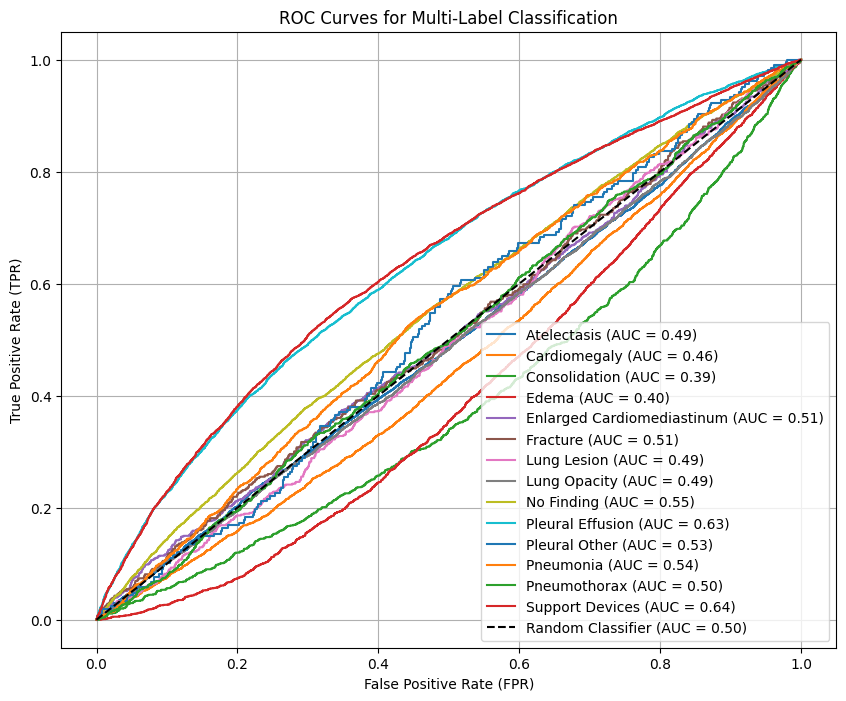

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Number of diseases (labels)
num_labels = y_test.shape[1]
optimal_thresholds = []

# Plot ROC curves for each disease
plt.figure(figsize=(10, 8))

for i in range(num_labels):
    fpr, tpr, thresholds = roc_curve(y_test[labels].values[:, i], y_pred_probs[:, i])  # Compute FPR & TPR
    auc_score = auc(fpr, tpr)  # Compute AUC
    youden_j = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_j)]

    optimal_thresholds.append(best_threshold)

    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {auc_score:.2f})")

# Add diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Plot formatting
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Multi-Label Classification")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()


## Getting the model prediction dataframe

In [ ]:
y_pred_binary = (y_pred_probs > optimal_thresholds).astype(float)
y_pred_binary_df = pd.DataFrame(data = y_pred_binary,
                  columns = labels)

y_pred_binary_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21586,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21587,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
21588,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21589,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0


In [ ]:
pred_prefix = "predictions_"
df_disease = y_test.copy()
for label in labels:
  df_disease[pred_prefix + label] = y_pred_binary_df[label]
df_disease

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,...,predictions_Enlarged Cardiomediastinum,predictions_Fracture,predictions_Lung Lesion,predictions_Lung Opacity,predictions_No Finding,predictions_Pleural Effusion,predictions_Pleural Other,predictions_Pneumonia,predictions_Pneumothorax,predictions_Support Devices
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21586,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
21588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21589,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0


In [ ]:
# prompt: concat df_disease with subgropus dataframe
df_disease = pd.concat([df_disease, subgroups], axis=1)


In [ ]:
with open('kmeans_1500_dedup_model_prediction.pkl', 'wb') as f:
  pickle.dump(df_disease, f)

In [ ]:
def calcluate_overall_tpr(df_disease, labels, pred_prefix):
  TPR_per_disease = {}
  for disease in labels:
    predicted_disease_name = pred_prefix + str(disease)
    TPR = calculate_tpr(df_disease, predicted_disease_name, disease)
    TPR_per_disease[disease] = TPR
  return TPR_per_disease


def calcluate_overall_fpr(df_disease, labels, pred_prefix):
  FPR_per_disease = {}
  for disease in labels:
    predicted_disease_name = pred_prefix + str(disease)
    FPR = calculate_fpr(df_disease, predicted_disease_name, disease)
    FPR_per_disease[disease] = FPR
  return FPR_per_disease

In [ ]:
overall_tpr = calcluate_overall_tpr(df_disease, labels, pred_prefix)
overall_fpr = calcluate_overall_fpr(df_disease, labels, pred_prefix)

In [ ]:
overall_tpr

{'Atelectasis': np.float64(0.8131212723658051),
 'Cardiomegaly': np.float64(0.7896870074307588),
 'Consolidation': np.float64(0.808910891089109),
 'Edema': np.float64(0.8542713567839196),
 'Enlarged Cardiomediastinum': np.float64(0.7253613666228647),
 'Fracture': np.float64(0.6921241050119332),
 'Lung Lesion': np.float64(0.6719242902208202),
 'Lung Opacity': np.float64(0.7573409461663948),
 'No Finding': np.float64(0.7552816901408451),
 'Pleural Effusion': np.float64(0.8709737134394668),
 'Pleural Other': np.float64(0.8269230769230769),
 'Pneumonia': np.float64(0.7403350515463918),
 'Pneumothorax': np.float64(0.7196652719665272),
 'Support Devices': np.float64(0.9179014212276988)}

In [ ]:
overall_fpr

{'Atelectasis': np.float64(0.3439404594467886),
 'Cardiomegaly': np.float64(0.3314868804664723),
 'Consolidation': np.float64(0.30061707400029153),
 'Edema': np.float64(0.22345120978463176),
 'Enlarged Cardiomediastinum': np.float64(0.4027844455112818),
 'Fracture': np.float64(0.2462686567164179),
 'Lung Lesion': np.float64(0.22154888581380922),
 'Lung Opacity': np.float64(0.3731048121292024),
 'No Finding': np.float64(0.1768527918781726),
 'Pleural Effusion': np.float64(0.20730125393785903),
 'Pleural Other': np.float64(0.31641958565215356),
 'Pneumonia': np.float64(0.3894405908478467),
 'Pneumothorax': np.float64(0.14669251272110492),
 'Support Devices': np.float64(0.17440074781331374)}

In [ ]:
with open('overall_tpr_originalll.pkl', 'wb') as f:
  pickle.dump(overall_tpr, f)

with open('overall_fpr_originalll.pkl', 'wb') as f:
  pickle.dump(overall_fpr, f)

In [ ]:

def calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, subgroup):
    subgroup_groups = df_disease[subgroup].unique()
    FPR_per_subgroup = {}
    for sub in subgroup_groups:
        df_subgroup = df_disease[df_disease[subgroup] == sub]
        FPR_per_subgroup[sub] = {}
        for disease in labels:
            predicted_disease_name = pred_prefix + str(disease)
            FPR = calculate_fpr(df_subgroup, predicted_disease_name, disease)
            FPR_per_subgroup[sub][disease] = FPR
    return FPR_per_subgroup

def calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, subgroup):
    subgroup_groups = df_disease[subgroup].unique()
    TPR_per_subgroup = {}
    for sub in subgroup_groups:
        df_subgroup = df_disease[df_disease[subgroup] == sub]
        TPR_per_subgroup[sub] = {}
        for disease in labels:
            predicted_disease_name = pred_prefix + str(disease)
            TPR = calculate_tpr(df_subgroup, predicted_disease_name, disease)
            TPR_per_subgroup[sub][disease] = TPR
    return TPR_per_subgroup


In [ ]:


FPR_per_race = calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, 'race')
TPR_per_race = calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, 'race')

FPR_per_gender = calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, 'gender')
TPR_per_gender = calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, 'gender')

FPR_per_age = calculate_fpr_per_subgroup(df_disease, labels, pred_prefix, 'anchor_age')
TPR_per_age = calculate_tpr_per_subgroup(df_disease, labels, pred_prefix, 'anchor_age')

<ipython-input-142-5cdd6bac317d>:4: RuntimeWarning: invalid value encountered in scalar divide
  return TP / (TP + FN)


In [ ]:

combined_metrics = {
    'race': {'FPR': FPR_per_race, 'TPR': TPR_per_race},
    'gender': {'FPR': FPR_per_gender, 'TPR': TPR_per_gender},
    'age': {'FPR': FPR_per_age, 'TPR': TPR_per_age},
}


In [ ]:
import pickle

def save_df_to_pickle(df, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(df, f)

save_df_to_pickle(combined_metrics, 'OGDataMetrics.pkl')